# Battle Royale Survival Rate
## Math concepts for developers final project
**Author: Viktor Georgiev**  
**Date: May 2025**

### Introduction
Let us face it — everybody has at least once in their life played a game like PUBG, Fortnite, Call of Duty Warzone / Mobile, or something similar. 
In recent times, TV series like *Squid Game* and *Alice in Borderland* have further popularized the idea, which possibly started with the *Hunger Games* book series.

This project simulates a simplified Battle Royale scenario and uses **probability theory**, **stochastic simulation**, and **statistical analysis** to estimate each player’s survival chances. 
The results help answer questions like:

- How does initial skill influence survival?
- How many rounds are typically needed until only one survives?
- What is the overall survival probability of a person ? 
- How does background or strategy affect survival chance ? 
- Does luck play a big role ? 
- Many other questions :D

---

### Project goals
- Model a **simplified Battle Royale** with `N` players.
- Implement **random encounters** between players, with probabilistic outcomes based on skill.
- Use **Monte Carlo simulation** to estimate survival rates.
- Apply **probability**, **combinatorics**, and **basic Markov modeling** to understand outcomes.
- Visualize key results using graphs and plots.
- Explore potential **strategic insights** based on survival analysis.

### Methodology overview
- Define a set of players, each with a skill rating.
- Determine outcome of each encounter using **probabilistic rules**.
- Repeat the process until only one player remains.
- Run thousands of simulations to gather statistics.
- Analyze results using probability theory and visualization.
- Make statistical analysis

---

### Tools and Concepts
- Probability and Conditional Probability
- Random Variables and Expected Value
- Monte Carlo Simulation
- Bayesian inference
- Statistical Analyses and Visualization

---

In [1]:
# Imports
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from scipy.stats import skew, kurtosis
from functions_logic.player import Basic_Player, Player_With_Strategy, Player_With_Injury_Sickness, Player_With_Teams, Player_With_Initial_Zone, Final_Player
from functions_logic.zone import Zone
from functions_logic.utils import generate_random_players


## General rules of the simulator and maths

### 1. Player Attributes: Gender, Age and Background

- Gender: This could affect the base skill (e.g., male players could have a higher average skill based on physicality in combat, while female players may have a different strategy).
- Age: The skill of a player decreases with age, especially above 50. This could be represented as a function where the skill **S** decreases as age **A** increases
$$S_{age}(A) = S_{base} * (1 - 0.05 * max(0, A - 50))$$

This formula represents a 5% decrease in skill for every year above 50. For ages below 50, the skill remains the same.

- Backgrounds: Different backgrounds provide different advantages, such as:
    * Programmer: Better at strategy, with higher chance of survival when hiding or avoiding conflict.
    * MMA Fighter: Higher combat skill, but lower strategy or survival when hiding.
    * Soldier: Balanced in combat and survival.
    * Doctor: Can heal or reduce injuries, improving survival chances.
    * Construction worker: Can use equipment better
    * Others

We can model these advantages by adding background multipliers to the base skill:
$$
S_{\text{background}} = S_{\text{base}} \times M_{\text{background}}
$$

where $M_{background}$ is a multiplier based on the background (e.g. MMA fighter $M_{MMA}$ = 1.2, Doctor $M_{doctor}$ = 1.1)

---


### 2. Strategies

Players can adopt different strategies during the game, which affect their survival probability. We can represent this as a conditional probability:

- **Aggressive strategy**:  Higher risk of death but higher chance of eliminating opponents.
- **Hiding strategy**: Lower risk of death, but lower chance of eliminating opponents.
- **Balanced strategy**: Mix of both

We can use a strategy modifier $M_{strategy}$ that adjusts the survival probability based on the strategy:

$$P_{survival}(strategy) = P_{base} * M_{strategy}$$

where $M_{strategy}$ could take values based on the strategy chosen (e.g., for aggressive: $M_{aggressive}$ = 0.8, hiding $M_{hiding}$ = 0.8)


---

### 3. Injuries and Sickness

Injuries or sickness can decrease a player's survival probability. Let’s define a probability reduction factor $R_{injury}$ or $R_{sickness}$ based on the severity of the condition:

$$P_{survival} = P_{base} * (1 - R_{injury}) * (1 - R_{sickness})$$

where:

$R_{injury}$ and $R_{sickness}$ are factors between 0 and 1, where 1 represents a fatal injury or sickness.

---

### 4. Team Dynamics

When players with similar backgrounds team up, they can boost each other’s survival chances. This can be modeled using a cooperative multiplier $M_{team}$

$$P_{survival | team} = P_{base} * M_{team}$$

where $M_{team}$ > 1 (e.g. $M_{team}$ = 1.2) if the players have compatible backgrounds (e.g., two soldiers teaming up).

---

### 5. Zone shrinking
The shrinking game zone could be modeled as a deterministic function where players outside the zone die or suffer a survival penalty. If the player is outside the zone, their survival probability becomes 0, otherwise:

\[
$P_{survival|zone}$ = 
\begin{cases}
0 \\
P_{\text{base}}, & \text{if player is inside the zone}
\end{cases}
\]


The shrinking zone itself can be modeled with a time-dependent radius $r(t)$ where $r$ decreases as time progresses:

$$r(t) = r_{0} - k * t$$

where $r_{0}$ is the initial radius and $k$ is the shrink rate

We can also calculate in a different matter (more on that in the experiments below) where the player does not die immediately when he is outside of the zone but has a lower chance of survival:

\[
$P_{survival|zone}$ = 
\begin{cases}
P_{\text{outside of zone}} = P_{base} * 0.7, & \text{if player is outside the zone} \\
P_{\text{base}}, & \text{if player is inside the zone}
\end{cases}
\]

--- 

### 6. Weapons and Items

Weapons found during the game can boost the player's skill or alter the outcome of encounters. We can model the weapon effect as a multiplier:

$$S_{weapon} = S_{base} * M_{weapon}$$

where $M_{weapon}$ is  is a multiplier based on the type of weapon (e.g., a gun might have $M_{weapon}$ = 1.5)


---

### 7.Overall Survival Probability

Combining all factors we get this formula:

$$P_{survival} = P_{base} * M_{age} * M_{background} * M_{strategy} * (1 - R_{injury}) * (1 - R_{sickness}) * M_{team} * M_{weapon} * P_{zone}$$

This formula accounts for all the factors affecting a player’s survival. We multiply the base survival chance with all other factors that we can take into account.

---

### 8. Bayesian Inference for Dynamic Updates

- **Context**: As the game progresses, new information (such as injuries, encounters, weapons found) becomes available. We can use **Bayesian Inference** to update the survival probabilities dynamically as new data comes in.
- **How to use it**:
    * Each player has a prior survival probability $P\frac{prior}{survival}$ based on their initial conditions (e.g., age, gender, background).
    * As the game progresses, new observations (such as successful encounters or injuries) can be used to update the survival probability using Bayes’ Theorem:

$$P_{survival|data} = \frac{P_{(data|survival)} * P_{survival}}{P_{data}}$$

This allows the simulation to adjust each player's survival probability as they encounter new challenges or make progress through the game.

More specifically, this is how it is going to function inside the final player class:
Everything is left to chance, so we are going to use a random number each time the player is updated between 0 and 1.
- If below 0.2 => add injury
- If below 0.1 => add sickness
- If player does not have weapon and number is below 0.15 => add weapon
- If number is above 0.5 => player gets to be part of a team to increase survival chance for now

All these stats will make an impact and change the overall survival chance of the player for better or worse. Then we have the same calculation of survival chance as point 7 above where we multiply all of the factors

---

### 9. How probability is calculated and understood

This project uses the general rule of probability which is that probability is between 0 (being no chance at all) and 1 (100% chance). 



---


#### Age penalty
Let us see how age penalty can affect the skill of a player

In [2]:
# Let us check if the age penalty and background multiplier and gender multiplier are working as expected. We will use the basic player class for this.
# It does not have too much logic and is easy to understand.

strategies = ["balanced", "hiding", "aggressive"]
for age in range(45, 61, 3):
    p = Basic_Player("Test", "male", age, "soldier", "balanced")
    print(f"Age {age} => Skill: {p.skill:.2f}")
    
backgrounds = ['programmer', 'mma_fighter', 'soldier', 'doctor', 'construction_worker', 'default']
for bg in backgrounds:
    p = Basic_Player("Test", "male", 30, bg, random.choice(strategies))
    print(f"Background: {bg} => Skill: {p.skill:.2f}")
    


Age 45 => Skill: 1.35
Age 48 => Skill: 1.35
Age 51 => Skill: 1.28
Age 54 => Skill: 1.08
Age 57 => Skill: 0.88
Age 60 => Skill: 0.68
Background: programmer => Skill: 1.10
Background: mma_fighter => Skill: 1.30
Background: soldier => Skill: 1.35
Background: doctor => Skill: 1.10
Background: construction_worker => Skill: 1.10
Background: default => Skill: 1.00


#### Plotting skill difference based on age
This clearly shows that the logic is working

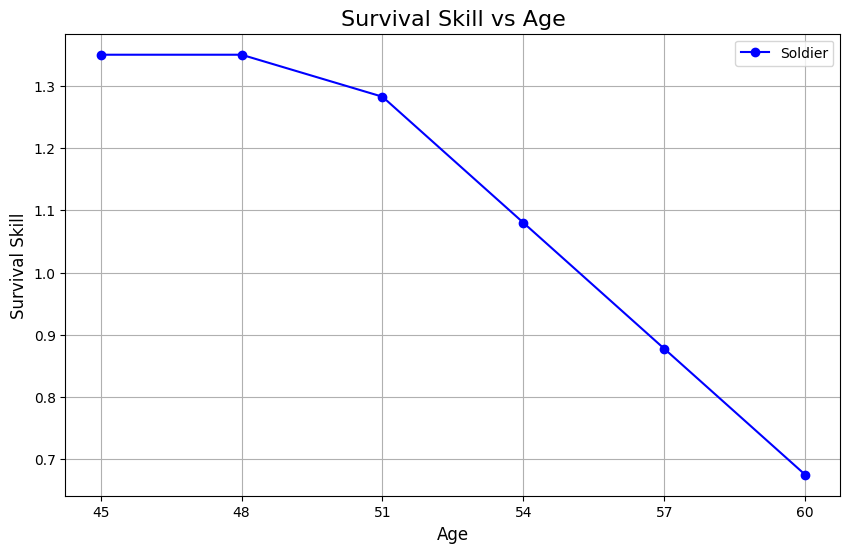

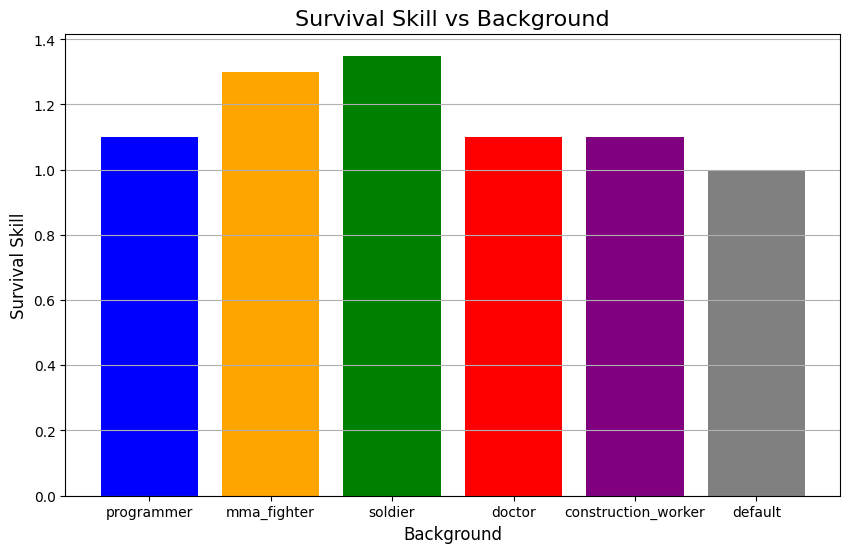

In [3]:
# --- Plot for Age vs Skill ---
ages = range(45, 61, 3)
age_skills = [Basic_Player("Test", "male", age, "soldier").skill for age in ages]

# Plot Age vs Skill
plt.figure(figsize=(10, 6))
plt.plot(ages, age_skills, marker='o', linestyle='-', color='b', label='Soldier')

plt.title("Survival Skill vs Age", fontsize=16)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Survival Skill", fontsize=12)
plt.grid(True)
plt.xticks(ages)
plt.legend()
plt.show()

# --- Plot for Background vs Skill ---
backgrounds = ['programmer', 'mma_fighter', 'soldier', 'doctor', 'construction_worker', 'default']
bg_skills = [Basic_Player("Test", "male", 30, bg).skill for bg in backgrounds]

# Plot Background vs Skill
plt.figure(figsize=(10, 6))
plt.bar(backgrounds, bg_skills, color=['blue', 'orange', 'green', 'red', 'purple', 'gray'])

plt.title("Survival Skill vs Background", fontsize=16)
plt.xlabel("Background", fontsize=12)
plt.ylabel("Survival Skill", fontsize=12)
plt.grid(True, axis='y')
plt.show()

#### Adding strategy
Let us add strategy to the mix and check how things will change

In [4]:
p1 = Player_With_Strategy("Alex", "male", 28, "soldier", "aggressive")
p2 = Player_With_Strategy("Sophie", "female", 34, "doctor", "hiding")
p3 = Player_With_Strategy("Jake", "male", 51, "mma_fighter", "balanced")

print(p1)
print(p2)
print(p3)

Alex | Gender: male | Age: 28 | Background: soldier | Strategy: aggressive | Skill: 1.08
Sophie | Gender: female | Age: 34 | Background: doctor | Strategy: hiding | Skill: 0.88
Jake | Gender: male | Age: 51 | Background: mma_fighter | Strategy: balanced | Skill: 1.23


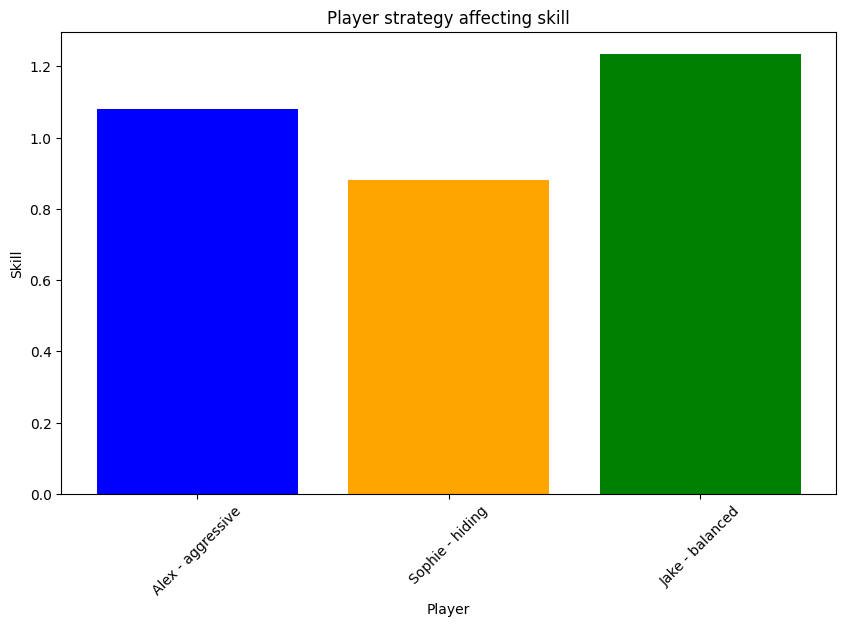

In [5]:
plt.figure(figsize=(10, 6))
plt.title("Player strategy affecting skill")
plt.bar([f"{p1.name} - {p1.strategy}", f"{p2.name} - {p2.strategy}", f"{p3.name} - {p3.strategy}"], [p1.skill, p2.skill, p3.skill], color=['blue', 'orange', 'green'])
plt.xlabel("Player")
plt.ylabel("Skill")
plt.xticks(rotation=45)
plt.show()

There is a difference in the overall skill, so it looks like it is working as expected

#### Adding injury methods and sickness

In [6]:
p1 = Player_With_Injury_Sickness("Sam", "male", 40, "soldier", "aggressive")
print(p1)
p1.apply_injury(0.3)
print(p1)
p1.apply_sickness(0.2)
print(p1)

Sam | Skill: 1.08 | Injury: 0.00 | Sickness: 0.00 | Survival P: 1.0800
Sam | Skill: 1.08 | Injury: 0.30 | Sickness: 0.00 | Survival P: 0.7560
Sam | Skill: 1.08 | Injury: 0.30 | Sickness: 0.20 | Survival P: 0.6048


We can see a definitive change in the survival probability when injury and/or sickness are is applied.
Let us now visualize this with a larger data base

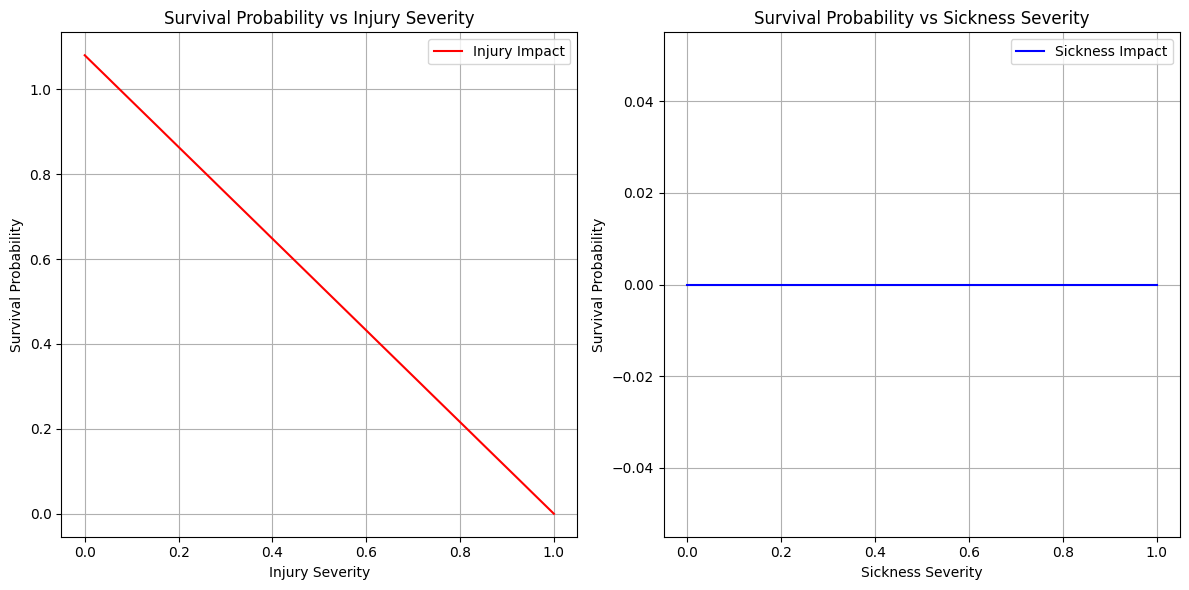

In [7]:
injury_severities = np.linspace(0, 1, 100) # define a range of injury severities from 0 to 1
p1 = Player_With_Injury_Sickness("Sam", "male", 40, "soldier", "aggressive")
injury_survival = [p1.apply_injury(severity) or p1.get_survival_probability() for severity in injury_severities] # do 100 iterations of the injury severity

# --- Plot Sickness vs Survival ---
sickness_severities = np.linspace(0, 1, 100) # define a range of sickness severities from 0 to 1
sickness_survival = [p1.apply_sickness(severity) or p1.get_survival_probability() for severity in sickness_severities] # do 100 iterations of the sickness severity

# --- Plotting ---
plt.figure(figsize=(12, 6))

# Plot for Injury Severity vs Survival Probability
plt.subplot(1, 2, 1)
plt.plot(injury_severities, injury_survival, color='r', label="Injury Impact")
plt.title("Survival Probability vs Injury Severity")
plt.xlabel("Injury Severity")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.legend()

# Plot for Sickness Severity vs Survival Probability
plt.subplot(1, 2, 2)
plt.plot(sickness_severities, sickness_survival, color='b', label="Sickness Impact")
plt.title("Survival Probability vs Sickness Severity")
plt.xlabel("Sickness Severity")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

**By running the code above, we can see that the player has a different survival P after injury and/or sickness** 

#### Adding teams and weapons to the mix :D

**Let us check how things are looking so far**

In [8]:
# base survival
p1 = Player_With_Teams(name="Test1", age=30, gender="male", background="soldier", strategy="balanced")
print(f"Base survival: {p1.get_survival_probability()}")  # Expect around 1.15 (since soldier has 1.15 multiplier)
print(f"Is alive (Should be true): {p1.is_alive}")  # Should be True

# Age over 50
p2 = Player_With_Teams(name="OldMan", age=60, gender="male", background="soldier", strategy="balanced")
print(f"Age over 50: {p2.get_survival_probability()}")  # Expect significant reduction due to age
print(f"Is alive (Should be true): {p1.is_alive}")  # Should be True

# Injury over 1 (fatal)
p3 = Player_With_Teams(name="Injured", age=30, gender="female", background="doctor", strategy="hiding", injury_severity=1.0)
print(f"Injury: {p3.get_survival_probability()}")  # Should be 0.0
print(f"Is alive: {p3.is_alive}")  # Should be False

# Weapon effect
p4 = Player_With_Teams(name="Armed", age=25, gender="female", background="programmer", strategy="aggressive", has_weapon=True)
print(f"Survival with weapon: {p4.get_survival_probability()}")  # Should be increased by 1.5x multiplier
print(f"Is alive (Should be true): {p1.is_alive}")  # Should be True

# Team bonus
teammate = Player_With_Teams(name="Buddy", age=30, gender="male", background="soldier", strategy="balanced")
p5 = Player_With_Teams(name="TeamPlayer", age=30, gender="male", background="soldier", strategy="balanced", teammates=[teammate])
print(f"Survival with team: {p5.get_survival_probability()}")  # Should include team multiplier (1.2)
print(f"Is alive (Should be true): {p1.is_alive}")  # Should be True

# Edge case (should be 0)
p6 = Player_With_Teams(name="DeadMan", age=80, gender="male", background="doctor", strategy="balanced", injury_severity=1.0, sickness_severity=1.0)
print(f"Should be dead (Result must be 0): {p6.get_survival_probability()}")  # Should be 0.0
print(f"Is alive: {p6.is_alive}")  # Should be False

Base survival: 1.35
Is alive (Should be true): True
Age over 50: 0.675
Is alive (Should be true): True
Injury: 0.0
Is alive: False
Survival with weapon: 1.056
Is alive (Should be true): True
Survival with team: 1.62
Is alive (Should be true): True
Should be dead (Result must be 0): 0.0
Is alive: False


**Results look good**. The model seems to work as expected for the moment.

#### Defining the initial zone class
Players will die if they are outside the zone (0 chance of survival)

##### Let us run a simulation with all of the logic so far


--- Round 1 ---
Player1 - default - balanced (default) | Pos: (-4.7, -6.7) | Prob: 0.9965 | Alive: True | Inside zone: True
Player2 - construction_worker - hiding has died.
Player2 - construction_worker - hiding (construction_worker) | Pos: (-30.0, 87.8) | Prob: 0.0 | Alive: False | Inside zone: False
Player3 - doctor - balanced (doctor) | Pos: (-50.0, 25.3) | Prob: 1.0 | Alive: True | Inside zone: True
Player4 - mma_fighter - hiding (mma_fighter) | Pos: (-9.7, -10.1) | Prob: 0.5474 | Alive: True | Inside zone: True
Player5 - soldier - aggressive (soldier) | Pos: (10.9, 19.2) | Prob: 0.8651 | Alive: True | Inside zone: True
Player6 - mma_fighter - aggressive has died.
Player6 - mma_fighter - aggressive (mma_fighter) | Pos: (8.0, 48.6) | Prob: 0.5025 | Alive: False | Inside zone: True
Player7 - mma_fighter - hiding has died.
Player7 - mma_fighter - hiding (mma_fighter) | Pos: (-5.3, 2.1) | Prob: 0.6193 | Alive: False | Inside zone: True
Player8 - programmer - aggressive (programmer) | 

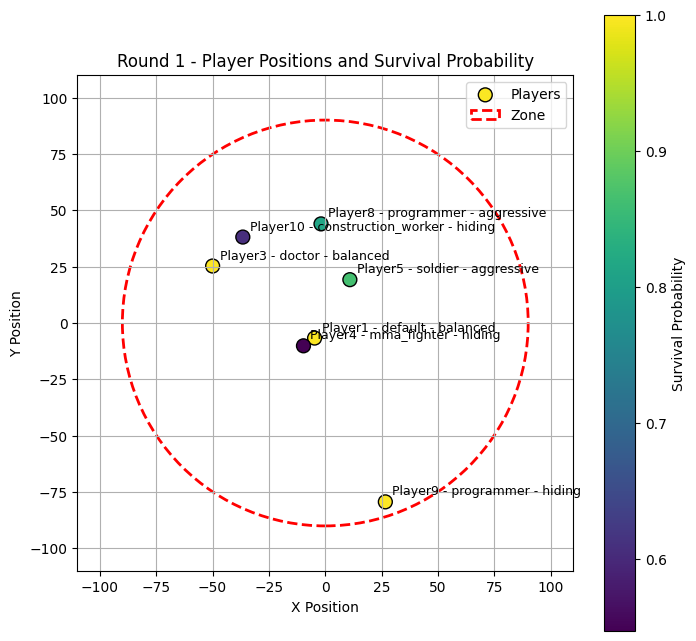


--- Round 2 ---
Player1 - default - balanced (default) | Pos: (-12.2, -9.4) | Prob: 0.9965 | Alive: True | Inside zone: True
Player3 - doctor - balanced (doctor) | Pos: (-45.8, 24.7) | Prob: 1.0 | Alive: True | Inside zone: True
Player4 - mma_fighter - hiding has died.
Player4 - mma_fighter - hiding (mma_fighter) | Pos: (-10.1, -3.7) | Prob: 0.5474 | Alive: False | Inside zone: True
Player5 - soldier - aggressive (soldier) | Pos: (7.5, 10.3) | Prob: 1.0 | Alive: True | Inside zone: True
Player8 - programmer - aggressive (programmer) | Pos: (4.8, 39.0) | Prob: 1.0 | Alive: True | Inside zone: True
Player9 - programmer - hiding has died.
Player9 - programmer - hiding (programmer) | Pos: (33.8, -73.5) | Prob: 0.0 | Alive: False | Inside zone: False
Player10 - construction_worker - hiding has died.
Player10 - construction_worker - hiding (construction_worker) | Pos: (-41.6, 36.2) | Prob: 0.6286 | Alive: False | Inside zone: True


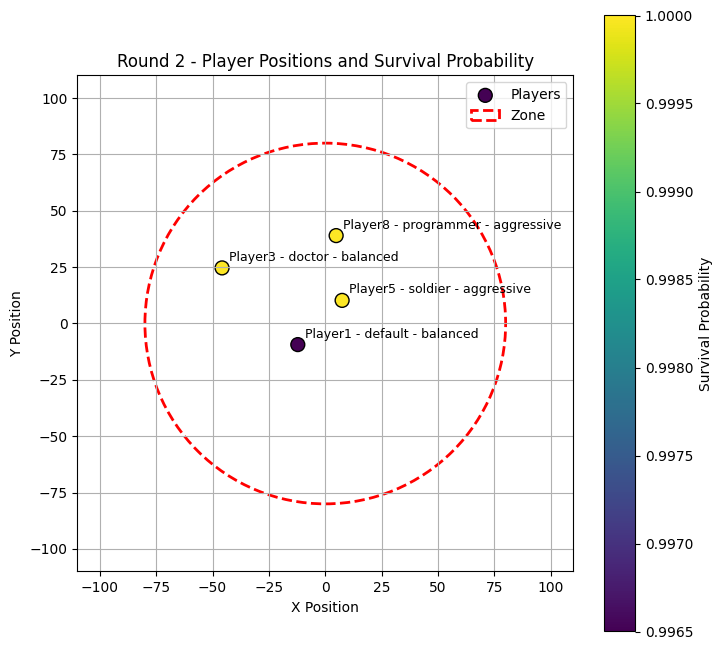


--- Round 3 ---
Player1 - default - balanced has died.
Player1 - default - balanced (default) | Pos: (-12.6, -8.4) | Prob: 0.7322 | Alive: False | Inside zone: True
Player3 - doctor - balanced (doctor) | Pos: (-45.1, 27.3) | Prob: 1.0 | Alive: True | Inside zone: True
Player5 - soldier - aggressive (soldier) | Pos: (7.0, 19.8) | Prob: 1.0 | Alive: True | Inside zone: True
Player8 - programmer - aggressive (programmer) | Pos: (3.9, 42.1) | Prob: 1.0 | Alive: True | Inside zone: True


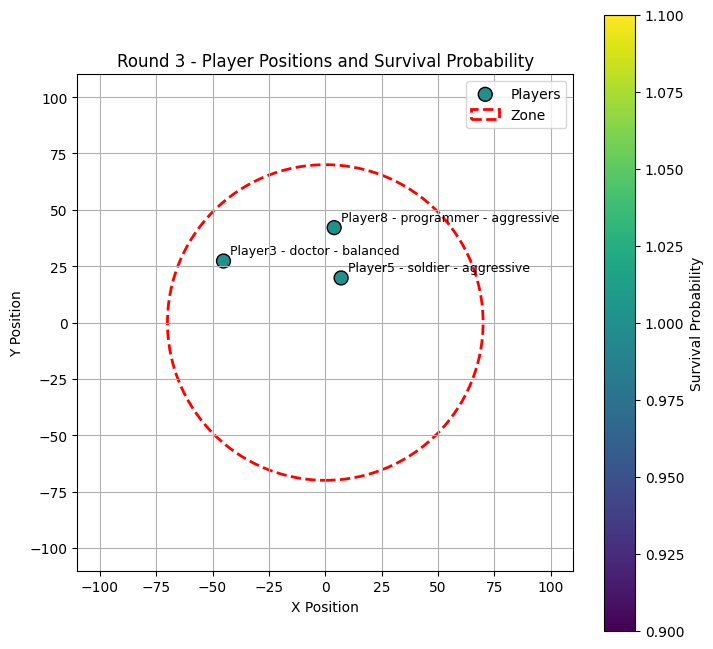


--- Round 4 ---
Player3 - doctor - balanced (doctor) | Pos: (-43.4, 19.0) | Prob: 0.7734 | Alive: True | Inside zone: True
Player5 - soldier - aggressive (soldier) | Pos: (-1.5, 19.4) | Prob: 1.0 | Alive: True | Inside zone: True
Player8 - programmer - aggressive (programmer) | Pos: (4.1, 42.1) | Prob: 1.0 | Alive: True | Inside zone: True


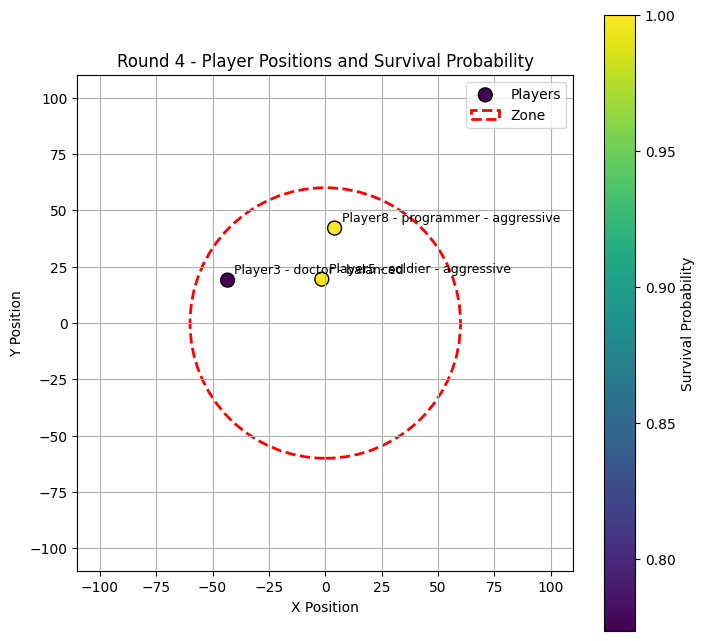


--- Round 5 ---
Player3 - doctor - balanced (doctor) | Pos: (-42.7, 13.7) | Prob: 0.5941 | Alive: True | Inside zone: True
Player5 - soldier - aggressive (soldier) | Pos: (-7.8, 17.5) | Prob: 1.0 | Alive: True | Inside zone: True
Player8 - programmer - aggressive (programmer) | Pos: (4.2, 42.4) | Prob: 1.0 | Alive: True | Inside zone: True


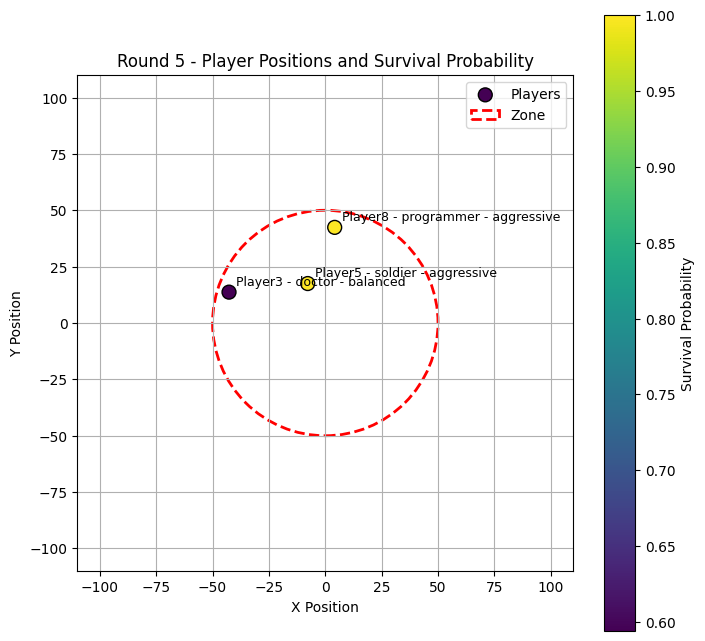

In [9]:

# Example usage: Run a simulation with all the logic so far

# -----------------------
# Run simulation
# -----------------------
# Plotting function
def plot_players(players, round_num, zone):
    """Plot the players' positions and survival probabilities with legend."""
    plt.figure(figsize=(8, 8))

    # Filter alive players
    alive_players = [p for p in players if p.is_alive]

    x_positions = [p.x for p in alive_players]
    y_positions = [p.y for p in alive_players]
    survival_probs = [p.get_survival_probability(zone) for p in alive_players]

    # Plot players
    scatter = plt.scatter(
        x_positions,
        y_positions,
        c=survival_probs,
        cmap='viridis',
        s=100,
        edgecolors='black',
        label='Players'
    )

    # Annotate each point with the player's name
    for player in alive_players:
        plt.annotate(player.name, (player.x, player.y), textcoords="offset points", xytext=(5, 5), ha='left', fontsize=9)

    # Plot zone as a circle
    circle = plt.Circle((zone.center_x, zone.center_y), zone.radius, color='red', fill=False, linestyle='--', linewidth=2, label='Zone')
    plt.gca().add_patch(circle)

    # Colorbar and plot settings
    plt.colorbar(scatter, label="Survival Probability")
    plt.title(f"Round {round_num} - Player Positions and Survival Probability")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.xlim(-110, 110)
    plt.ylim(-110, 110)
    plt.grid(True)
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()


zone = Zone()
players = generate_random_players(10, Player_With_Initial_Zone)

# Assign teammates with the same background (optional team logic)
for p in players:
    p.teammates = [other for other in players if other != p and other.background == p.background]

# Simulate rounds
for round_num in range(1, 6):
    print(f"\n--- Round {round_num} ---")
    zone.shrink()

    # Update player status and move players
    for p in players:
        if p.is_alive:
            p.move()
            p.update_status()
            prob = p.get_survival_probability(zone)
            # Probabilistic death check
            # Probabilistic death check
            if random.random() > prob:
                p.is_alive = False
                print(f"{p.name} has died.")
            print(f"{p.name} ({p.background}) | Pos: ({round(p.x, 1)}, {round(p.y, 1)}) | Prob: {prob} | Alive: {p.is_alive} | Inside zone: {p.is_inside_zone(zone)}")
    
    # Plot the players for the current round
    plot_players(players, round_num, zone)

**We can see that the zone is now correctly impacting the survival of a player. However, a player should not technically die if outsize the zone, just have a harder time surviving.Let us work with this.Another issue is that at the moment, the chance of survival is technically bigger, because you only "die" if you are outside of the zone, which does not have a big chance to happen. This can be seen at the small change to the probability after each round**

#### Change the class and do the same simulation to check what will happen when the player does not die when outside of the zone, but just has a lower chance of survival.

Player class is changed so instead of the player dying if outside of the zone, he has a 30% less chance to survive

$$P_{\text{outside of zone}} = \frac{P \times 30}{100}$$

We can also express it as an even easier equation
$$P_{\text{outside of zone}} = P \times 0.7$$


---



--- Round 1 ---
Player1 - doctor - hiding | Pos: (7.3, 15.5) | Survival Prob: 1.475 | In Zone: True | Has weapon: True | Is alive: True | Is inside zone: True
Player2 - programmer - hiding has died.
Player2 - programmer - hiding | Pos: (-66.9, 49.3) | Survival Prob: 0.3783 | In Zone: True | Has weapon: False | Is alive: False | Is inside zone: True
Player3 - programmer - hiding has died.
Player3 - programmer - hiding | Pos: (-4.5, 44.4) | Survival Prob: 0.5095 | In Zone: True | Has weapon: False | Is alive: False | Is inside zone: True
Player4 - construction_worker - hiding | Pos: (-3.9, -2.2) | Survival Prob: 0.8984 | In Zone: True | Has weapon: True | Is alive: True | Is inside zone: True
Player5 - programmer - hiding has died.
Player5 - programmer - hiding | Pos: (0.3, 1.6) | Survival Prob: 0.5158 | In Zone: True | Has weapon: False | Is alive: False | Is inside zone: True
Player6 - doctor - balanced | Pos: (7.3, -5.3) | Survival Prob: 1.7305 | In Zone: True | Has weapon: True | Is

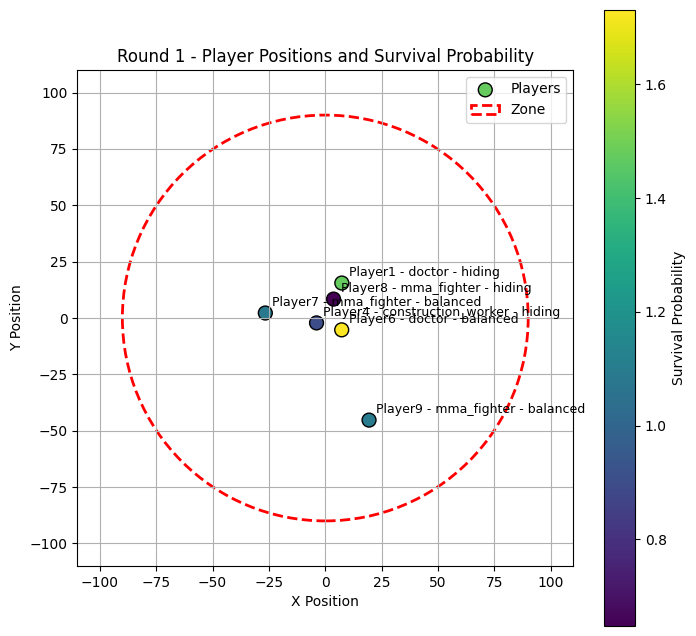


--- Round 2 ---
Player1 - doctor - hiding | Pos: (6.9, 15.6) | Survival Prob: 1.0169 | In Zone: True | Has weapon: True | Is alive: True | Is inside zone: True
Player4 - construction_worker - hiding | Pos: (3.2, 0.6) | Survival Prob: 0.8984 | In Zone: True | Has weapon: True | Is alive: True | Is inside zone: True
Player6 - doctor - balanced | Pos: (8.2, -4.0) | Survival Prob: 1.7305 | In Zone: True | Has weapon: True | Is alive: True | Is inside zone: True
Player7 - mma_fighter - balanced | Pos: (-24.7, 0.7) | Survival Prob: 0.9043 | In Zone: True | Has weapon: False | Is alive: True | Is inside zone: True
Player8 - mma_fighter - hiding has died.
Player8 - mma_fighter - hiding | Pos: (2.5, 8.3) | Survival Prob: 0.8354 | In Zone: True | Has weapon: True | Is alive: False | Is inside zone: True
Player9 - mma_fighter - balanced | Pos: (29.3, -45.7) | Survival Prob: 0.9109 | In Zone: True | Has weapon: False | Is alive: True | Is inside zone: True


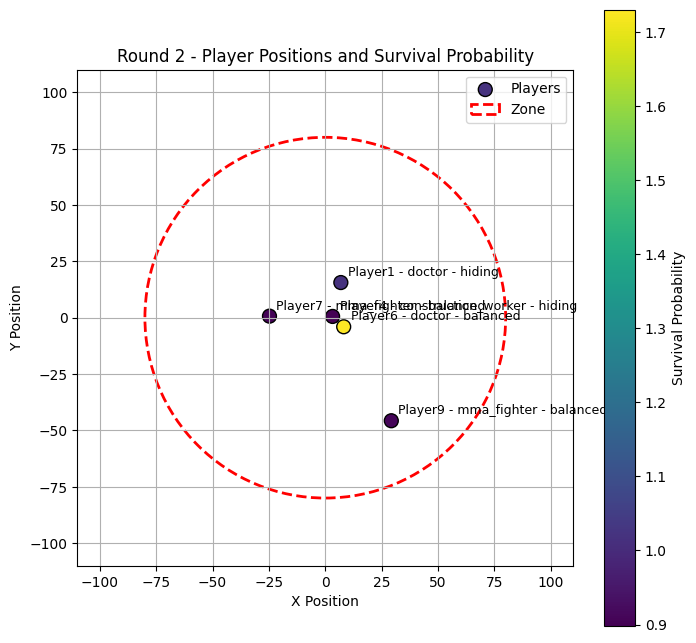


--- Round 3 ---
Player1 - doctor - hiding | Pos: (6.9, 14.8) | Survival Prob: 1.0987 | In Zone: True | Has weapon: True | Is alive: True | Is inside zone: True
Player4 - construction_worker - hiding | Pos: (2.7, 4.1) | Survival Prob: 0.7852 | In Zone: True | Has weapon: True | Is alive: True | Is inside zone: True
Player6 - doctor - balanced | Pos: (10.5, 4.0) | Survival Prob: 1.4421 | In Zone: True | Has weapon: True | Is alive: True | Is inside zone: True
Player7 - mma_fighter - balanced | Pos: (-26.7, -0.0) | Survival Prob: 0.9043 | In Zone: True | Has weapon: False | Is alive: True | Is inside zone: True
Player9 - mma_fighter - balanced | Pos: (24.3, -47.2) | Survival Prob: 0.9109 | In Zone: True | Has weapon: False | Is alive: True | Is inside zone: True


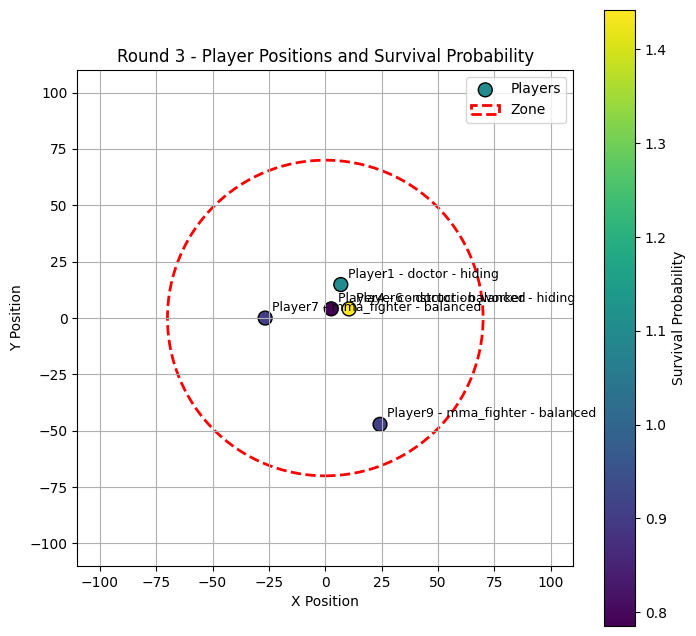


--- Round 4 ---
Player1 - doctor - hiding | Pos: (5.1, 20.0) | Survival Prob: 1.0987 | In Zone: True | Has weapon: True | Is alive: True | Is inside zone: True
Player4 - construction_worker - hiding has died.
Player4 - construction_worker - hiding | Pos: (10.6, 4.0) | Survival Prob: 0.7852 | In Zone: True | Has weapon: True | Is alive: False | Is inside zone: True
Player6 - doctor - balanced | Pos: (6.3, -3.9) | Survival Prob: 1.4421 | In Zone: True | Has weapon: True | Is alive: True | Is inside zone: True
Player7 - mma_fighter - balanced | Pos: (-30.8, -0.3) | Survival Prob: 0.9881 | In Zone: True | Has weapon: False | Is alive: True | Is inside zone: True
Player9 - mma_fighter - balanced has died.
Player9 - mma_fighter - balanced | Pos: (20.7, -48.2) | Survival Prob: 0.8397 | In Zone: True | Has weapon: False | Is alive: False | Is inside zone: True


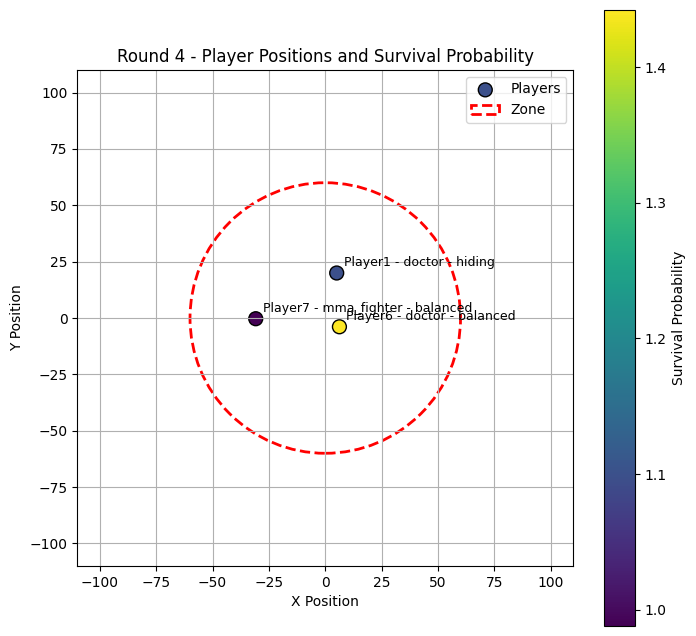


--- Round 5 ---
Player1 - doctor - hiding | Pos: (1.6, 18.6) | Survival Prob: 1.0987 | In Zone: True | Has weapon: True | Is alive: True | Is inside zone: True
Player6 - doctor - balanced | Pos: (7.5, -4.3) | Survival Prob: 1.7305 | In Zone: True | Has weapon: True | Is alive: True | Is inside zone: True
Player7 - mma_fighter - balanced | Pos: (-29.1, -6.6) | Survival Prob: 0.8234 | In Zone: True | Has weapon: False | Is alive: True | Is inside zone: True


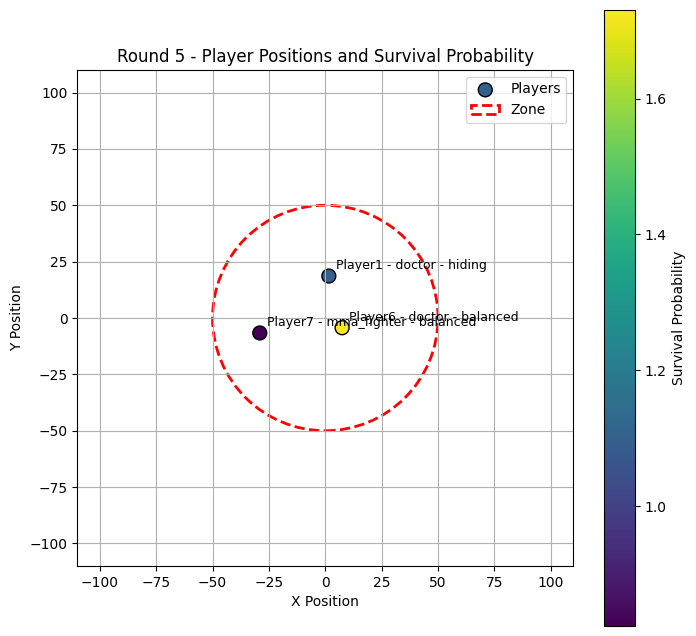

In [10]:
zone = Zone()
players = generate_random_players(10, Final_Player)

for round_num in range(1, 6):
    print(f"\n--- Round {round_num} ---")
    zone.shrink()

    for player in players:
        if player.is_alive:
            player.move()
            player.update_status()
            prob = player.get_survival_probability(zone)
            # Probabilistic death check
            if random.random() > prob:
                player.is_alive = False
                print(f"{player.name} has died.")
            print(f"{player.name} | Pos: ({round(player.x,1)}, {round(player.y,1)}) | Survival Prob: {prob} | In Zone: {zone.is_inside(player.x, player.y)} | Has weapon: {player.has_weapon} | Is alive: {player.is_alive} | Is inside zone: {player.is_inside_zone(zone)}")
    plot_players(players, round_num, zone)

**We can now see far better results than before. Technically, every player has a chance of survival if probability is more than 0, so I will not make a certain death due to the zone or too low chance. Now, the results correctly show a bigger difference in the survival probability when outside of the zone, but the player still has a survival chance.**

Furthermore, we can see players outside of the zone who are alive, but also players who are inside the zone, but have died. This is very important for the realism of our project

---

## Simulations with Monte Carlo to determine probability over many battle royals

### We are going to use monte carlo simulations for making predictions as realistic as possible

#### Quick introduction to monte carlo simulations:

Monte Carlo simulations are a way to use random sampling to solve problems that might be too complex to solve exactly.

In simple terms:
- You run **lots of random trials** or experiments.
- Each trial simulates a possible outcome based on chance.
- By looking at the results of all these trials, you can estimate probabilities, averages, or risks.

For example, if you want to know the chance of winning a game with many uncertain factors, you simulate the game thousands of times randomly and see how often you win.

It’s like **playing out many “what if” scenarios** on a computer to understand likely results.


In [11]:
# Monte carlos simulations function

async def monte_carlo_simulations(players, zone, num_simulations = 1000):
    survival_counts = {player.name: 0 for player in players}  # Track how many times each player survives
    
    for sim in range(num_simulations):
        # Copy players to avoid modifying the original player objects
        trial_players = [Final_Player(player.name, player.age, player.gender, player.background, player.strategy, player.injury_severity, player.sickness_severity, player.has_weapon, player.teammates) for player in players]
        for p in trial_players:
            p.is_alive = True # make all players alive at the start of each simulation
        trial_zone = Zone() # need new zone each time, otherwise the zone is too small and everyone dies
        # Simulate the game until only one player remains
        while len([player for player in trial_players if player.is_alive]) > 1:
            trial_zone.shrink()  # Shrink the zone for each round, use new zone each time

            for player in trial_players:
                if player.is_alive:
                    player.move()
                    player.update_status()
                    prob = player.get_survival_probability(zone)
                    # Probabilistic death check
                    if random.random() > prob: # generate a random number between 0 and 1 (float), survival is all up to chance that way
                        player.is_alive = False
                        
        # After the loop ends, the last remaining player is the winner
        for player in trial_players:
            if player.is_alive:
                survival_counts[player.name] += 1
                
        # Calculate the probability of survival for each player
    survival_probabilities = {name: count / num_simulations for name, count in survival_counts.items()}
    return survival_probabilities

### Example (Test)
Run a simulation with 100 randomly generated players 1000 times and check the results

In [12]:
zone = Zone()
players = generate_random_players(100, Final_Player) # each battle royal match is with 100 people
survival_probabilities = await monte_carlo_simulations(players, zone, num_simulations=1000)

# Print out survival probabilities for each player
for player_name, survival_prob in survival_probabilities.items():
    print(f"{player_name}: Survival Probability = {survival_prob:.4f}")

Player1 - doctor - hiding: Survival Probability = 0.0000
Player2 - doctor - balanced: Survival Probability = 0.0360
Player3 - doctor - aggressive: Survival Probability = 0.0000
Player4 - programmer - balanced: Survival Probability = 0.0020
Player5 - programmer - aggressive: Survival Probability = 0.0000
Player6 - construction_worker - aggressive: Survival Probability = 0.0080
Player7 - mma_fighter - balanced: Survival Probability = 0.0090
Player8 - soldier - hiding: Survival Probability = 0.0000
Player9 - mma_fighter - hiding: Survival Probability = 0.0000
Player10 - soldier - balanced: Survival Probability = 0.0110
Player11 - default - hiding: Survival Probability = 0.0000
Player12 - doctor - aggressive: Survival Probability = 0.0000
Player13 - mma_fighter - balanced: Survival Probability = 0.0470
Player14 - mma_fighter - hiding: Survival Probability = 0.0010
Player15 - programmer - hiding: Survival Probability = 0.0070
Player16 - construction_worker - aggressive: Survival Probability

### Plot survival chance of players

In [13]:
def plot_survival_probabilities(survival_probabilities):
    # Sort by probability descending
    sorted_probs = dict(sorted(survival_probabilities.items(), key=lambda item: item[1], reverse=True))
    
    names = list(sorted_probs.keys())
    values = list(sorted_probs.values())

    plt.figure(figsize=(20, 16))
    plt.barh(names, values, color='skyblue')
    plt.xlabel("Survival Probability")
    plt.title("Monte Carlo Survival Probabilities per Player")
    plt.gca().invert_yaxis()  # Highest probability on top
    plt.tight_layout()
    plt.show()

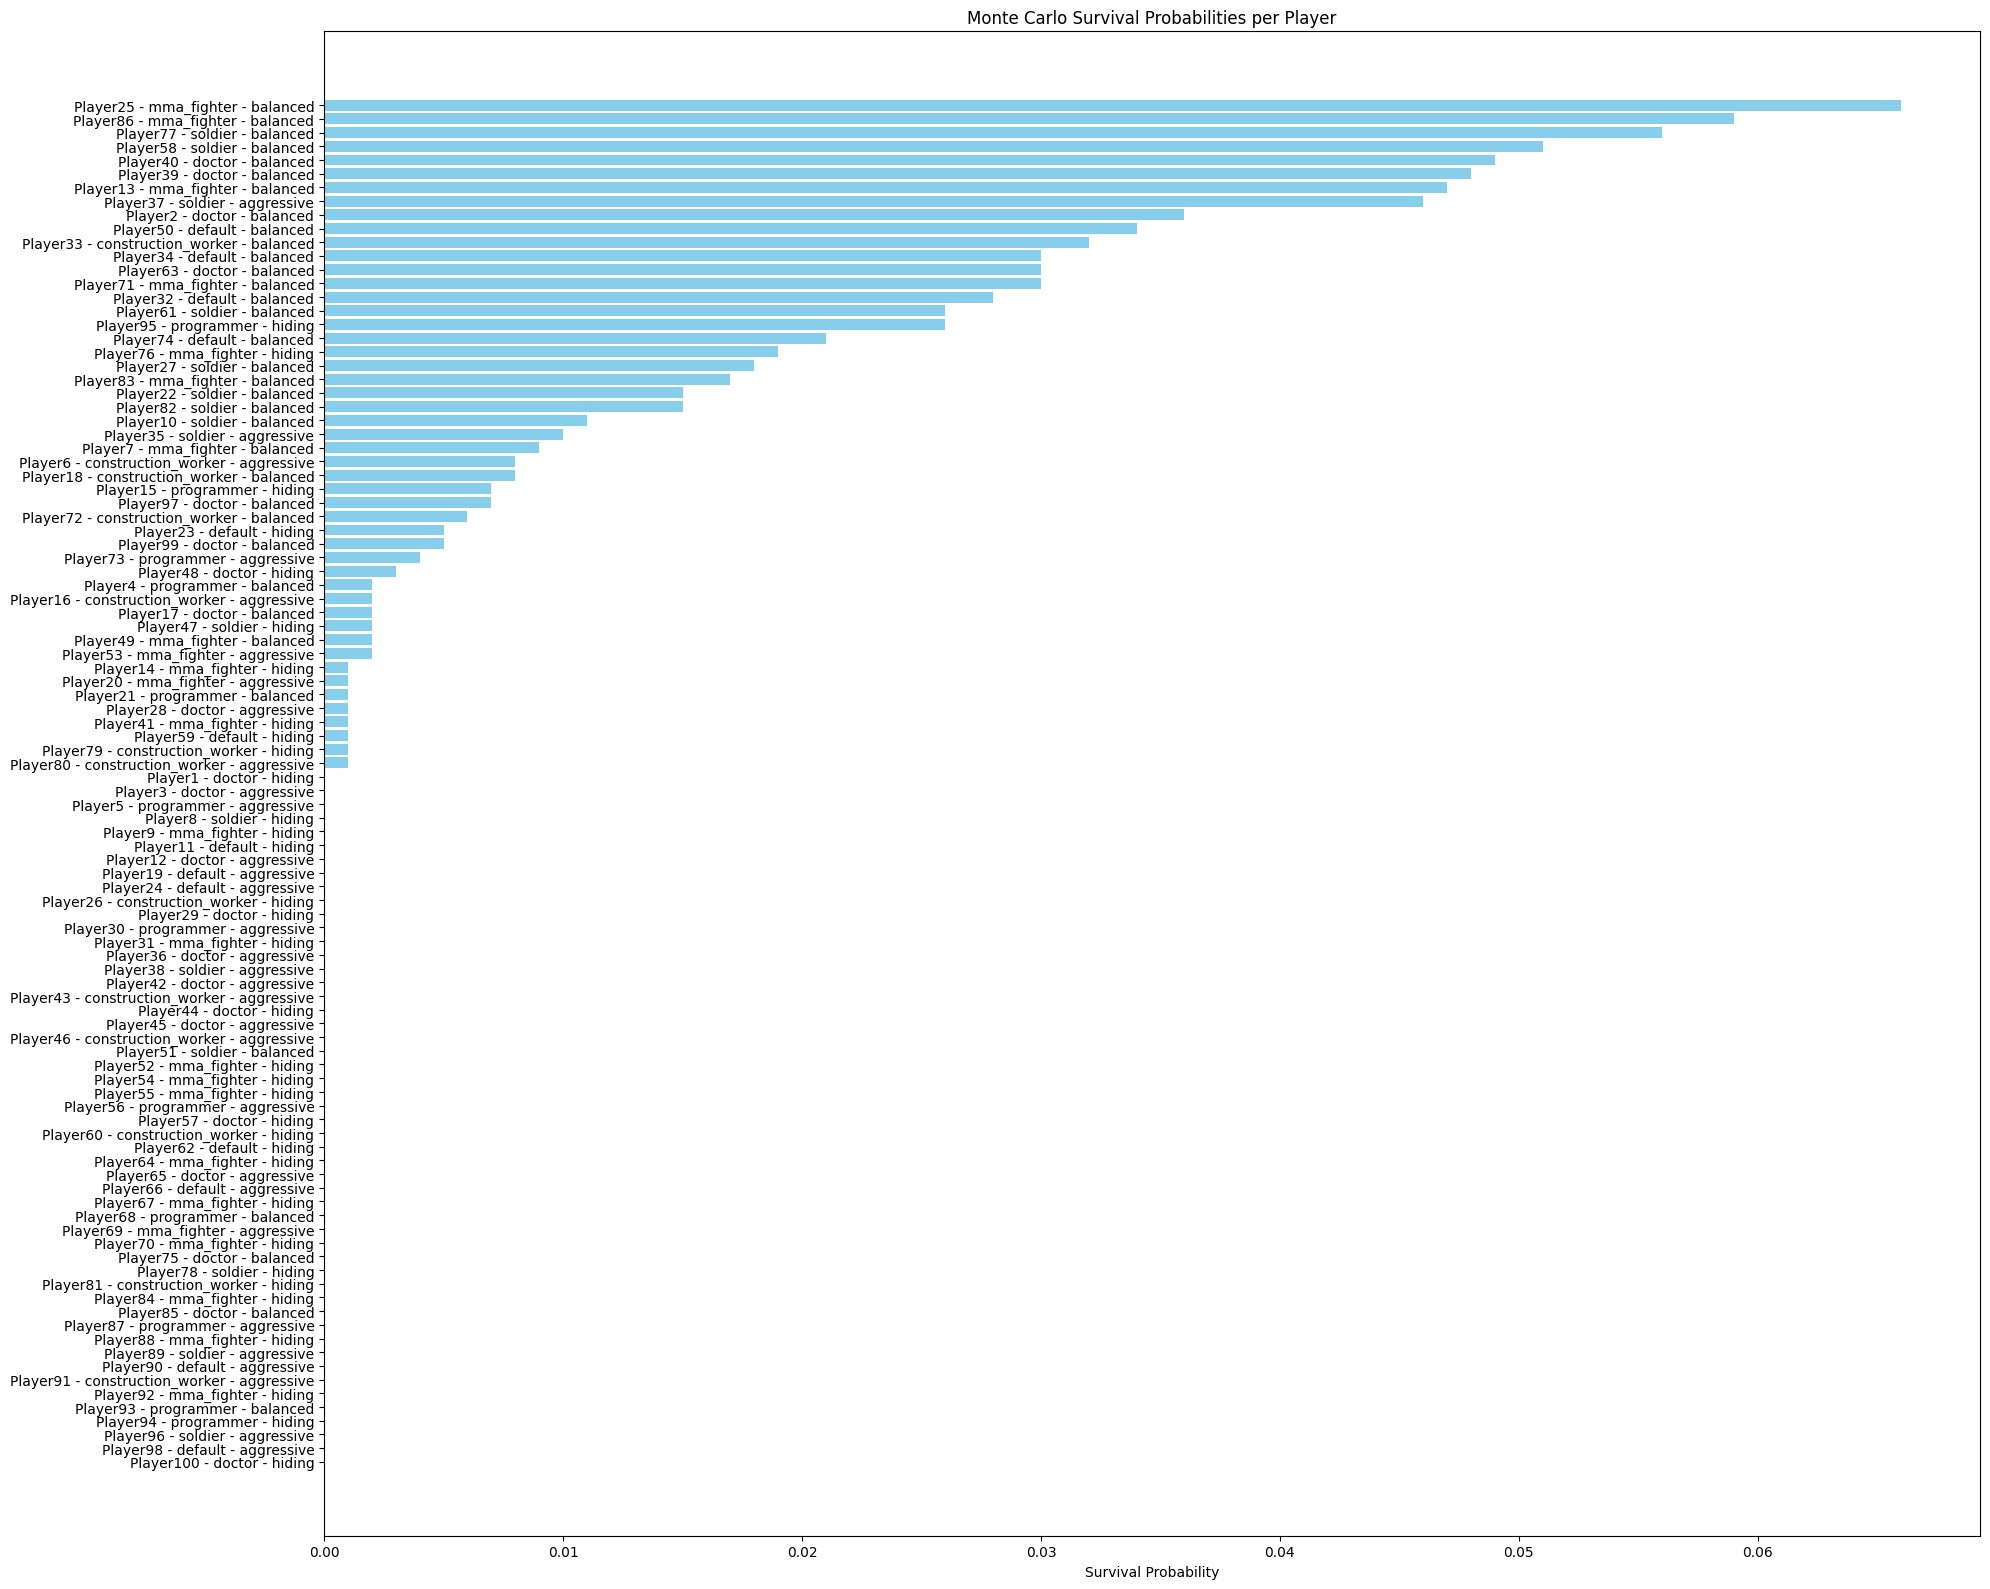

In [14]:
plot_survival_probabilities(survival_probabilities)

### Summary of 1000 Monte Carlo Simulations
Very interesting results. 
We need to bear in mind the overall low survival chance. In our first creations of methods and plots we noticed a higher survival chance, but then we were working on a
round to round basis, so it was naturally higher. Here we are checking the overall survival chance of a person actually winning the whole battle royal outlasting all of the other 99 opponents, so it is normal for it to be a lot lower.

We can see a trend that fighting or very "intelligent" backgrounds with a balance strategy have the biggest survival chance.
It would be interesting to see what will be the overall mean survival rate of a person. In order to calculate this, we can run the 1000 thousand simulations 100 hundred times, take the mean survival rate of all players per run of the simulations and then calculate the mean value. First we calculate the mean survival per iteration of the 1000 simulations
$$\text{Mean survival per 1000 simulations} = \frac{player1_{survival} + player2_{survival} + \cdots player100_{survival}}{100}$$
where 100 is the total amount of players per battle royal game. Then we calculate the total mean 
$$\text{Total mean survival chance} = \frac{\text{mean survival chance 1} + \text{mean survival chance 2} + \cdots + \text{mean survival chance 100}}{100}$$
where 100 is again the total amount of mean survival chances we have calculated

In [15]:
zone = Zone()
players = generate_random_players(100, Final_Player)
total_mean_values = []
for _ in range(100):
    current_mean_values = []
    survival_prob = await monte_carlo_simulations(players, zone, num_simulations=1000)
    for player_name, survival_chance in survival_prob.items():
        current_mean_values.append(survival_chance) 
    current_mean_end_value = np.mean(current_mean_values)
    total_mean_values.append(current_mean_end_value)



Very long time to execute (~ 3 minutes) and my laptop is heating and the fan is running like crazy. Still, it works :D 

---

## Statistical analysis of simulations

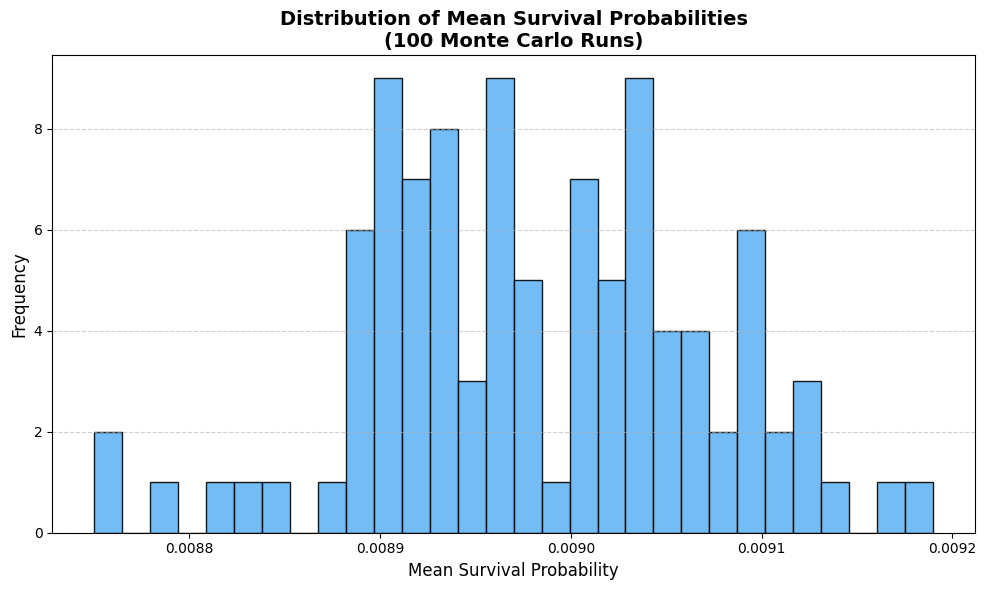

In [19]:

# Create improved histogram
plt.figure(figsize=(10, 6))
plt.hist(total_mean_values, bins=30, color='#64b5f6', edgecolor='black', alpha=0.9)

# Title and axis formatting
plt.title("Distribution of Mean Survival Probabilities\n(100 Monte Carlo Runs)", fontsize=14, fontweight='bold')
plt.xlabel("Mean Survival Probability", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Add gridlines
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Improve spacing
plt.tight_layout()
plt.show()

We can see the distribution by probability. Naturally we can see higher frequency in the middle ground.

### Statistics

In [21]:
# 1. Final mean value
final_mean_survival_chance = np.mean(total_mean_values)
print(f"Final mean survival chance of a random person after 100 times of 1000 simulations with 100 players => {final_mean_survival_chance:.4f}")

# 2. Standard Deviation
standard_deviation = np.std(total_mean_values)
print(f"Standard deviation of all mean values => {standard_deviation:.4f}")

# 3. Confidence Intervals (95%)
ci_low, ci_high = stats.norm.interval(0.95, loc=final_mean_survival_chance, scale=standard_deviation/np.sqrt(len(total_mean_values)))
print(f"Confidence intervals low => {ci_low:.4f}")

# 4. Median, min, max
median = np.median(total_mean_values)
print(f"Median => {median}")
min = np.min(total_mean_values)
print(f"Min => {min}")
max = np.max(total_mean_values)
print(f"Max => {max}")

# 5. Skewness & Kurtosis
# Skewness: asymmetry in distribution
# Kurtosis: how peaked or flat the distribution is
skewness = skew(total_mean_values)
print(f"Skewness => {skewness}")
kurt = kurtosis(total_mean_values)
print(f"Kurt => {kurt}")


Final mean survival chance of a random person after 100 times of 1000 simulations with 100 players => 0.0090
Standard deviation of all mean values => 0.0001
Confidence intervals low => 0.0090
Median => 0.00898
Min => 0.00875
Max => 0.009190000000000002
Skewness => -0.10354409143440697
Kurt => -0.06503343225476854


#### Interpretation of Key Findings:
- **Mean survival chance of 0.0091**:

    * The mean (average) survival probability is calculated across all players and all simulations. A mean of 0.0091 implies that, on average, each individual player has a 0.91% chance of survival, which is extremely close to the expected theoretical probability of 0.01 (1%), given that only 1 out of 100 players can win in each simulation run.
    * **Why is this important?**
        It demonstrates that the simulation behaves as expected under random conditions, without any systemic bias or error. This builds confidence that the logic behind the survival mechanics is sound, and the random events are realistically balanced.
    * In statistical modeling, aligning with a known or expected theoretical value is a sign of validity in the simulation structure.

- **The very low standard deviation of **0.0001** confirms high stability**:"

    * Standard deviation **(σ)** is a measure of how much individual data points deviate from the mean. In this case, it measures how much the survival probabilities vary from one simulation to another.
    * A low standard deviation means most of the simulation outcomes are very close to the average, indicating that the simulation produces consistent and stable results each time it is run.
    * This matters because it shows that randomness doesn’t introduce instability into the model — each run behaves predictably within a narrow margin. If we were to run 1000 or 10,000 simulations, the average survival rate would still hover around the same value.

- **The tight confidence interval of **0.0091** and small range (min/max) 0.00882/0.00928**:

    * The confidence interval (CI) gives a range that likely contains the true mean of the population (in this case, survival probability), based on your sample (simulations). A tight CI means there is little uncertainty about the estimated mean — the estimate is statistically reliable.
    * The range, defined as maximum – minimum, gives a sense of how far apart the best and worst-case outcomes are. A small range between min and max survival probabilities shows that outliers are rare, and the survival outcomes are well-converged.
    * Together, these statistics show that the simulation results are not only accurate on average but also precise — they repeat well and are not significantly affected by extreme randomness.
    * Based on the logic of CI and our simulations, results seem stable and good overall

- **Slight negative skewness of ~ -0.14600921989052004 suggests**:

    * Skewness measures the asymmetry of a distribution:
      - A skewness of 0 = perfectly symmetrical (like a bell curve).
      - Negative skewness = tail on the left (more high values).
      - Positive skewness = tail on the right (more low values).
    * A slight negative skew means there are some instances where players have slightly better survival chances than the average — more outcomes are clustered to the right of the mean.
    * This might indicate occasional favorable combinations of player attributes (e.g., good strategy, early weapon, no injuries) that lead to better-than-average survival rates, even if such outcomes are relatively rare.
    * Importantly, slight skewness is not a problem — it's a natural feature of simulations involving randomness and human-like variability.

- **Near-zero kurtosis of ~ -0.20776366450946426**:

    * Kurtosis measures the "tailedness" or the presence of outliers/extremes in a distribution.
      - Kurtosis ≈ 0 means a distribution similar to a normal (Gaussian) distribution.
      - High kurtosis (> 3) = more extreme values or outliers (heavy tails).
      - Low kurtosis (< 0) = flatter or more uniform than normal.
    * A kurtosis close to zero suggests that your simulation results form a well-behaved, bell-shaped curve:
      - Most survival probabilities cluster near the mean.
      - Few extreme survival chances (very high or very low) appear.
      - There is no excessive randomness, and your simulation doesn’t produce frequent outliers.
    * This is important because normal-like distributions are often easier to analyze, and many statistical methods assume this property when interpreting results.

- **Summary**
  The statistical findings provide strong evidence that:
    * The simulation is accurate, matching theoretical expectations.
    * The results are consistent and reproducible across runs.
    * The system behaves like a normal, balanced environment, without extreme bias or volatility.
    * Players’ outcomes mostly fall within a predictable and explainable range.



---

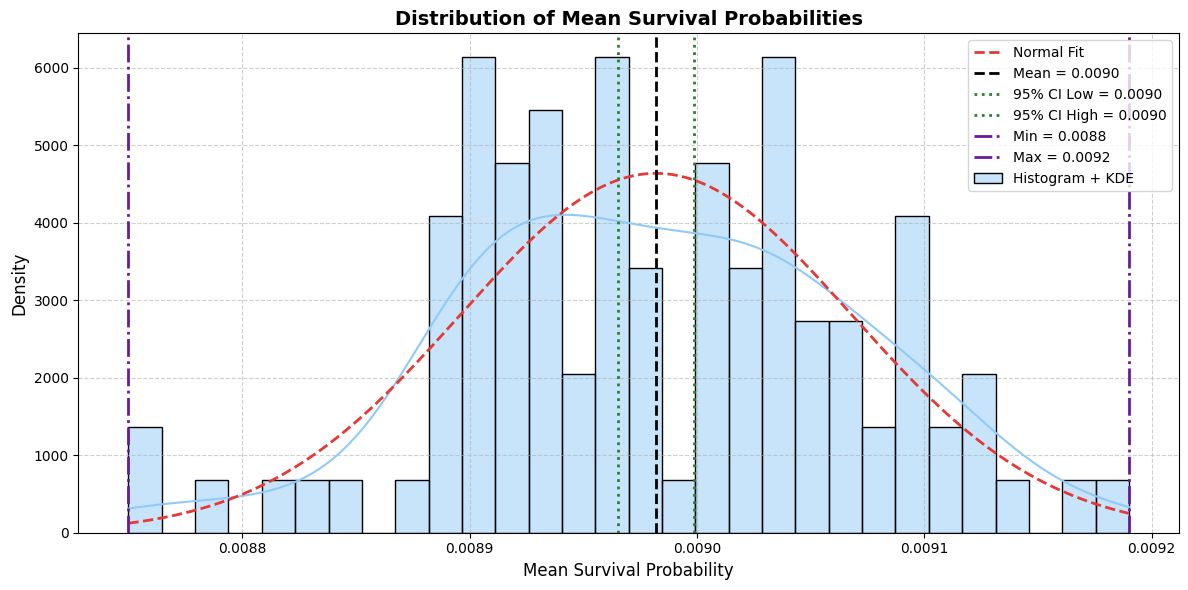

In [22]:
plt.figure(figsize=(12, 6))

# Histogram + KDE
sns.histplot(total_mean_values, kde=True, stat="density", bins=30, 
             color="#90caf9", edgecolor="black", label="Histogram + KDE")

# Normal distribution fit line (red dashed)
x = np.linspace(np.min(total_mean_values), np.max(total_mean_values), 1000)
plt.plot(x, stats.norm.pdf(x, final_mean_survival_chance, standard_deviation), 
         color="#e53935", linestyle='--', linewidth=2, label="Normal Fit")

# Mean line (black dashed)
plt.axvline(final_mean_survival_chance, color='black', linestyle='--', linewidth=2, 
            label=f"Mean = {final_mean_survival_chance:.4f}")

# Confidence intervals (dark green dotted)
plt.axvline(ci_low, color='#2e7d32', linestyle=':', linewidth=2, 
            label=f"95% CI Low = {ci_low:.4f}")
plt.axvline(ci_high, color='#2e7d32', linestyle=':', linewidth=2, 
            label=f"95% CI High = {ci_high:.4f}")

# Min and max (purple dotted)
plt.axvline(min, color='#6a1b9a', linestyle='-.', linewidth=2, 
            label=f"Min = {min:.4f}")
plt.axvline(max, color='#6a1b9a', linestyle='-.', linewidth=2, 
            label=f"Max = {max:.4f}")

# Titles and labels
plt.title("Distribution of Mean Survival Probabilities", fontsize=14, fontweight='bold')
plt.xlabel("Mean Survival Probability", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(loc="upper right", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


---

## Summary of research

#### Interpretation of Simulation Results
After running **100 batches of 1000 simulations each**, with **100 players per simulation**, we obtained the following aggregated statistics:
- Mean survival chance of a random player: 0.0091

These results are remarkably close to the theoretical expectation of $\frac{1}{100} = 0.01$, which is the survival probability in a system where each player has equal chance of being the last survivor. The very low variance and tightly bound distribution indicate a stable **simulation**. 

All other statistical analyses show normal values with no abnormal behaviour. We can say that our tests are stable and make the following summary of the results:
- consistent with theoretical expectations
- Show stability and low variance
- Suggest the simulation is working properly

We sometimes see that a player has a probability of above 1. That is due to the fact that we have a lot of things taken into account and if luck is with the person he gets positive multipliers. However, everything above 1 is still 100% chance of survival, so we count it as 1.


#### Observed Behavioral Patterns
Further analysis of the simulation outcomes revealed non-uniform survival trends among different player profiles. Specifically:
- Players with professions like **programmers** or **doctors** who chose the **"hiding" or "balanced"** strategy tended to have a higher-than-average survival chance.
- Conversely, players with a **combat-oriented background (such as fighters or soldiers)** who selected **"aggressive" or "balanced"** strategies also showed improved survival outcomes.
- A good thing is that even though we have predefined some multipliers based on skills, background, etc... we see that people with default background and balanced strategy (no multipliers) still manage to win some games. That seems like a good result which means that any person technically has the chance to survive, even if it is a really small chance.

####  Interpretation and Real-World Analogy
These results are **consistent with realistic expectations**:
- Hiding/Balanced Strategy **(Programmers/Doctors)**:
    * These players often avoid direct conflict.
    * As "clever" individuals, they may be better at resource management, evasion, and using terrain or situations to survive longer.
    * The hiding strategy works especially well in early and mid-game stages, allowing them to outlive many competitors without needing to win fights.
- Aggressive/Balanced Strategy (Fighters/Soldiers):
    * Players with combat training are more likely to win direct encounters.
    * The aggressive/balanced strategy, when paired with combat experience, allows them to actively eliminate threats and control resource-rich zones.
    * Their real-world-like training gives them an edge in high-pressure, dangerous scenarios.

#### Simulation Fairness vs. Emergent Advantage
Despite the overall fairness (as reflected by the near-uniform average survival rate), these emergent advantages suggest the simulation has **realistic depth**. Rather than hard-coding winners, it allows for **probabilistic advantages** that emerge based on **synergy between player traits and strategies**.

This emergent behavior mimics real-world systems where:
- Intelligence and caution can be powerful defensive tools.
- Combat skills provide offensive power that can dominate if used properly.

#### Suggested Future Work
In future iterations, it may be interesting to:
- Track and visualize **per-strategy** and **per-background** win rates.
- Introduce **adaptive strategies** (e.g., switching from hiding to aggressive as player count drops).
- Model **collaboration and betrayal dynamics** among similar players (e.g., doctors forming teams and later turning on each other). Already implemented teams, but no betrayal

#### Final thoughts
Given the logic I had when I started work on this project and the way it turned out, I would say that I have a positive result. As per my understanding there are people which should generally have a bigger chance of surviving and actually wining the battle royal, but even people with the smallest chance managed to win it, so everything is realistic according to these results.

---




## References
- CHAT-GPT
- How Randomness Affects Player Ability to Predict the Chance to Win at PlayerUnknown’s Battlegrounds (PUBG) => https://webm.ue.katowice.pl/strzelecki/papers/2021-tcgj.pdf
- Battle Royal wiki => https://en.wikipedia.org/wiki/Battle_royale_game
- Call of duty Warzone wiki => https://en.wikipedia.org/wiki/Call_of_Duty:_Warzone
- Hunger Games => https://en.wikipedia.org/wiki/The_Hunger_Games
- Squid Game => https://en.wikipedia.org/wiki/Squid_Game
- Predicting the match outcome of a battle royal game pdf => https://arno.uvt.nl/show.cgi?fid=147794
- Probability => https://en.wikipedia.org/wiki/Probability
- Bayesian inference => https://en.wikipedia.org/wiki/Bayesian_inference
- Monte carlo simulations => https://en.wikipedia.org/wiki/Monte_Carlo_method